### Stage 1: Data Ingestion

- [ ] Define Configuration for Interacting with Kaggle Public API
- [ ] Download Kaggle Dataset using Kaggle Credentials and Save Data to `data` directory
- [ ] Create a Pipeline that automates data ingestion for any publically available Kaggle Dataset


#### Configuration

In [1]:
import os
os.chdir('../')
print(f'Current Working Directory: {os.getcwd()}')

Current Working Directory: /mnt/e/Research/deepgloberoadextraction/deepgloberoadextraction


In [2]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataIngestionConfig:
    # Kaggle Credentials from secrets.yaml
    username: str
    token: str
    # config.yaml
    download_dir: Path
    dataset_id: str

from DeepGlobeRoadExtraction import CONFIG_FILE_PATH, SECRETS_FILE_PATH
from DeepGlobeRoadExtraction.utils.common import read_yaml, create_directories

class ConfigurationManager:
    def __init__(self, config_filepath = CONFIG_FILE_PATH, secrets_filepath = SECRETS_FILE_PATH) -> None:
        self.config = read_yaml(config_filepath)
        self.secrets = read_yaml(secrets_filepath)
        create_directories([self.config.data_ingestion.download_dir])
    
    def get_data_ingestion_config(self) -> DataIngestionConfig:
        config = self.config.data_ingestion
        secrets = self.secrets.kaggle
        cfg = DataIngestionConfig(
            download_dir=Path(config.download_dir),
            dataset_id=config.dataset_id,
            username=secrets.username,
            token=secrets.token
        )
        return cfg
    
cfg = ConfigurationManager().get_data_ingestion_config()
cfg

[2024-06-09 15:26:54,863: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-09 15:26:54,871: INFO: common: yaml file: secrets.yaml loaded successfully]
[2024-06-09 15:26:54,872: INFO: common: created directory at: data]


DataIngestionConfig(username='adityasharma47', token='be3010af43521b24f19c27b661d318f0', download_dir=PosixPath('data'), dataset_id='balraj98/deepglobe-road-extraction-dataset')

#### Components

In [3]:
import os
import subprocess
import json
from DeepGlobeRoadExtraction import logger

class DataIngestionComponents:
    def __init__(self, config: DataIngestionConfig) -> None:
        self.config = config

    def initialise_kaggle(self):
        logger.info(f'---------- Initialising Kaggle Account ----------')
        # Set Path for Kaggle Configration File
        KAGGLE_CONFIG_DIR = os.path.join(os.path.expandvars('$HOME'), '.kaggle')
        KAGGLE_CONFIG_FILE = os.path.join(KAGGLE_CONFIG_DIR, 'kaggle.json')
        
        # Check if kaggle.json already exists and is not empty
        if os.path.exists(KAGGLE_CONFIG_FILE) and os.path.getsize(KAGGLE_CONFIG_FILE) > 0:
            logger.warning(f'---> Kaggle Account Credentials Found ==> {KAGGLE_CONFIG_FILE}. Remove this file and re-initialse if API token is invalid or has expired.')
            return
        
        # Otherwise create .kaggle directory
        os.makedirs(KAGGLE_CONFIG_DIR, exist_ok=True)
        
        try:
            username = self.config.username
            token = self.config.token
            api_dict = {'username': username, 'key': token}
            
            # Create a kaggle.json file inside .kaggle folder and add your credentials
            with open(KAGGLE_CONFIG_FILE, "w", encoding="utf-8") as f:
                json.dump(api_dict, f)
            
            # Change File Permissions
            cmd = f"chmod 600 {KAGGLE_CONFIG_FILE}"
            output = subprocess.check_output(cmd.split(" "))
            output = output.decode(encoding="utf-8")
        except Exception as e:
            logger.error('Failed to Initialise Kaggle Account!')
            raise e
        
    # Download Kaggle Dataset
    def download_dataset(self):
        from kaggle.api.kaggle_api_extended import KaggleApi
        logger.info(f'---------- Downloading Kaggle Dataset: {self.config.dataset_id} ----------')
        try:
            api = KaggleApi()
            api.authenticate()
            api.dataset_download_files(
                dataset=self.config.dataset_id,
                path=self.config.download_dir,
                unzip=True,
                force=False,
                quiet=True
            )
            logger.info('---> Download Complete!')
        except Exception as e:
            logger.error('Kaggle dataset download failed!')
            raise e

#### Pipeline

In [4]:
class DataIngestionPipeline:
    def __init__(self) -> None:
        pass
    
    def main(self):
        config = ConfigurationManager().get_data_ingestion_config()
        pipeline = DataIngestionComponents(config=config)
        pipeline.initialise_kaggle()
        pipeline.download_dataset()
        
DataIngestionPipeline().main()

[2024-06-09 15:27:13,189: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-09 15:27:13,191: INFO: common: yaml file: secrets.yaml loaded successfully]
[2024-06-09 15:27:13,193: INFO: common: created directory at: data]
[2024-06-09 15:27:13,193: INFO: 4097356871: ---------- Initialising Kaggle Account ----------]
[2024-06-09 15:27:14,494: INFO: 4097356871: ---------- Downloading Kaggle Dataset: balraj98/deepglobe-road-extraction-dataset ----------]
Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset
[2024-06-09 15:34:33,291: INFO: 4097356871: ---> Download Complete!]


### Stage 2: Data Preparation
- [ ] Read `metadata.csv` 
- [ ] Split training images into training and validation split using random state from `params.yaml`
- [ ] Export updated metadata with split group column as a new metadata.csv file called `metadataV2.csv` and save to data directory

In [1]:
import os
os.chdir('../')
print(f'Current Working Directory: {os.getcwd()}')

Current Working Directory: /mnt/e/Research/deepgloberoadextraction/deepgloberoadextraction


#### Configuration

In [2]:
from dataclasses import dataclass
from pathlib import Path
from typing import List

@dataclass(frozen=True)
class DataPreparationConfig:
    # config.yaml
    data_directory: Path
    metadata_csv: Path
    out_metadata_csv: Path
    # params.yaml
    random_state: int
    train_val_split: List[float]
    
from DeepGlobeRoadExtraction import CONFIG_FILE_PATH, PARAMS_FILE_PATH
from DeepGlobeRoadExtraction.utils.common import read_yaml

class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH) -> None:
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
    
    def get_data_preparation_config(self) -> DataPreparationConfig:
        config = self.config.data_preparation
        params = self.params
        cfg = DataPreparationConfig(
            data_directory=Path(config.data_dir),
            metadata_csv=Path(config.metadata_csv),
            random_state=params.random_state,
            train_val_split=params.train_val_split,
            out_metadata_csv=Path(config.out_metadata_csv)
        )
        return cfg
    
cfg = ConfigurationManager().get_data_preparation_config()
print(cfg)

[2024-06-09 15:42:17,100: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-09 15:42:17,107: INFO: common: yaml file: params.yaml loaded successfully]
DataPreparationConfig(data_directory=PosixPath('data'), metadata_csv=PosixPath('data/metadata.csv'), out_metadata_csv=PosixPath('data/metadataV2.csv'), random_state=26, train_val_split=BoxList([0.7, 0.2, 0.1]))


#### Components

In [3]:
from DeepGlobeRoadExtraction import logger
import pandas as pd
from sklearn.model_selection import train_test_split

class DataPreparationComponents:
    def __init__(self, config: DataPreparationConfig) -> None:
        self.config = config
        
    def load_metadata(self):
        logger.info(f'------------- Loading Metadata -------------')
        metadata_df = pd.read_csv(self.config.metadata_csv) # Read Metadata
        metadata_df = metadata_df[metadata_df['split']=='train'] # Filter all rows that have 'train' in the 'split' column
        metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']] # Keep only 'image_id', 'sat_image_path' and 'mask_path' columns
        metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(self.config.data_directory, img_pth)) # Add data_directory to sat_image_path
        metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(self.config.data_directory, img_pth)) # Add data_directory to mask_path
        self.metadata = metadata_df 
    
    def split_dataset(self):
        logger.info(f'------------- Splitting Training Dataset into Train and Validation -------------')
        metadata_df = self.metadata
        # Shuffle DataFrame
        metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
        # Perform split for train / val
        train_df, valid_df = train_test_split(metadata_df, train_size=self.config.train_val_split[0], random_state=self.config.random_state)
        valid_df, test_df = train_test_split(valid_df, train_size=self.config.train_val_split[1]/(self.config.train_val_split[1]+self.config.train_val_split[2]), random_state=self.config.random_state)
        train_df['group'] = 'train'
        valid_df['group'] = 'val'
        test_df['group'] = 'test'
        # Concatenate DataFrames
        self.metadata = pd.concat([train_df, valid_df, test_df])
        # Export Metadata
        self.metadata.to_csv(self.config.out_metadata_csv, index=False)
        del train_df, valid_df, test_df, metadata_df

#### Pipeline

In [4]:
class DataPreparationPipeline:
    def __init__(self) -> None:
        pass
    
    def main(self):
        config = ConfigurationManager().get_data_preparation_config()
        pipeline = DataPreparationComponents(config=config)
        pipeline.load_metadata()
        pipeline.split_dataset()
        
DataPreparationPipeline().main()

[2024-06-09 15:42:24,224: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-09 15:42:24,227: INFO: common: yaml file: params.yaml loaded successfully]
[2024-06-09 15:42:24,227: INFO: 3406445105: ------------- Loading Metadata -------------]
[2024-06-09 15:42:24,282: INFO: 3406445105: ------------- Splitting Training Dataset into Train and Validation -------------]


### Stage 3: Model Training and Evaluation

- [ ] Read `data/metadataV2.csv' 
- [ ] Create PyTorch Lightning Data Module
  - Input Arguments: `metadataV2.csv`, `batch_size`, `augmentations`, `prefetch_factor`, `num_workers`, and `resize_dimensions`
- [ ] Initialise Model
  - [ ] Load Weights [Optional]
  - [ ] Learing Rate Tuner 
- [ ] Train Model
- [ ] Evaluate Model
- [ ] Save Model as ONNX, .pth, and State Dict

In [1]:
import os
os.chdir('../')
print(f'Current Working Directory: {os.getcwd()}')

Current Working Directory: /mnt/e/Research/deepgloberoadextraction/deepgloberoadextraction


In [2]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)

class TrainingConfig:
    # config.yaml
    models_dir: Path
    metadata_csv: Path
    logs_dir: Path
    # params.yaml
    model_name: str
    num_classes: int
    num_channels: int
    epochs: int
    learning_rate: float
    batch_size: int
    precision: int
    accelerator: str
    num_workers: int
    prefetch_factor: int
    resize_dimension: int
    checkpoint_path: Path
    tune_lr: bool

from DeepGlobeRoadExtraction import CONFIG_FILE_PATH, PARAMS_FILE_PATH
from DeepGlobeRoadExtraction.utils.common import read_yaml

class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH) -> None:
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
    
    def get_training_config(self) -> TrainingConfig:
        config = self.config.training
        params = self.params
        cfg = TrainingConfig(
            models_dir=Path(config.models_dir),
            metadata_csv=Path(config.metadata_csv),
            logs_dir=Path(config.logs_dir),
            model_name=params.model_name,
            num_classes=params.num_classes,
            num_channels=params.num_channels,
            epochs=params.epochs,
            learning_rate=params.learning_rate,
            batch_size=params.batch_size,
            precision=params.precision,
            accelerator=params.accelerator,
            num_workers=params.num_workers,
            prefetch_factor=params.prefetch_factor,
            resize_dimension=params.resize_dimension,
            checkpoint_path=None if params.checkpoint_path == 'None' else Path(params.checkpoint_path),
            tune_lr=params.tune_lr,
        )
        return cfg
    
cfg = ConfigurationManager().get_training_config()
print(cfg)

[2024-06-10 02:26:15,260: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-10 02:26:15,263: INFO: common: yaml file: params.yaml loaded successfully]
TrainingConfig(models_dir=PosixPath('models'), metadata_csv=PosixPath('data/metadataV2.csv'), logs_dir=PosixPath('logs'), model_name='DeepLabV3Plus', num_classes=1, num_channels=3, epochs=25, learning_rate=0.0001, batch_size=12, precision=16, accelerator='auto', num_workers=32, prefetch_factor=12, resize_dimension=1024, checkpoint_path=PosixPath('models/checkpoints/epoch=07-val_f1=0.54.ckpt'), tune_lr=True)


In [3]:
from DeepGlobeRoadExtraction import logger
from DeepGlobeRoadExtraction.utils.dataloader import RoadsDataModule, get_training_augmentation
import importlib
import torch
import pytorch_lightning as pl
torch.set_float32_matmul_precision('medium')

class TrainingComponents:
    def __init__(self, config: TrainingConfig) -> None:
        self.config = config
        
    def create_dataloaders(self):
        logger.info(f'------------- Creating Dataloaders -------------')
        self.dm = RoadsDataModule(metadata_csv=self.config.metadata_csv, train_augmentation=get_training_augmentation(), resize_dimensions=self.config.resize_dimension, batch_size=self.config.batch_size, prefetch_factor=self.config.prefetch_factor, num_workers=self.config.num_workers)
    
    def initialise_model(self):
        logger.info(f'------------- Inistialising Model: {self.config.model_name} -------------')
        modelConstructor = getattr(importlib.import_module('DeepGlobeRoadExtraction.utils.models'), self.config.model_name)
        self.model = modelConstructor(n_channels=self.config.num_channels, n_classes=self.config.num_classes, lr=self.config.learning_rate)
    
    def load_checkpoint(self):
        if self.config.checkpoint_path is not None:
            logger.info('------------- Loading Checkpoint -------------')
            logger.info(f'Loading checkpoint from {self.config.checkpoint_path}')
            checkpoint = torch.load(self.config.checkpoint_path)
            self.model.load_state_dict(checkpoint['state_dict'])
            logger.info('Checkpoint loaded successfully')
        else:
            logger.warning('No checkpoint path provided, initializing model with random weights')
    
    def callbacks(self):
        logger.info('------------- Creating Callbacks -------------')
        ### Define Checkpoints for Early Stopping, Tensorboard Summary Writer, and Best Checkpoint Saving
        from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
        from pytorch_lightning.loggers import TensorBoardLogger

        # Early stopping callback
        self.early_stopping = EarlyStopping(
            monitor='val_loss',  # Metric to monitor
            patience=10,          # Number of epochs with no improvement after which training will be stopped
            verbose=True,
            mode='min'           # Mode can be 'min' for minimizing the monitored metric or 'max' for maximizing it
        )

        # Model checkpoint callback
        self.checkpoint_callback = ModelCheckpoint(
            monitor='val_f1',   # Metric to monitor
            filename='{epoch:02d}-{val_f1:.2f}',  # Filename format
            save_top_k=1,         # Save the top k models
            mode='max',           # Mode can be 'min' or 'max'
            verbose=True,
            dirpath=self.config.models_dir.joinpath('checkpoints')
        )

        # TensorBoard logger
        self.tensorboard_logger = TensorBoardLogger(
            save_dir=self.config.logs_dir,     # Directory to save the logs
            name=self.config.model_name       # Experiment name
        )

        from pytorch_lightning.callbacks import LearningRateMonitor

        # Learning rate monitor
        self.lr_monitor = LearningRateMonitor(logging_interval='epoch')
        
    def tune_lr(self):
        if self.config.tune_lr:
            from pytorch_lightning.tuner.tuning import Tuner
            logger.info('------------- Tunning Learning Rate -------------')
            # Define a separate trainer for hyperparameter tuning
            self.tuning_trainer = pl.Trainer(
                accelerator=self.config.accelerator,
                precision=self.config.precision,
                logger=self.tensorboard_logger,
                callbacks=None,
                max_epochs=5  # Set this to a low number for faster tuning
            )

            self.dm.setup('fit')

            # Hyperparameter tuning
            self.tuner = Tuner(self.tuning_trainer)
            self.new_lr = self.tuner.lr_find(self.model, train_dataloaders=self.dm.train_dataloader(), val_dataloaders=self.dm.val_dataloader()).suggestion()
            logger.info(f'Suggested learning rate: {self.new_lr.suggestion()}')
        else:
            logger.info('------------- Skipping Tunning Learning Rate -------------')
        
    def create_trainer(self):
        logger.info(f'------------- Training Model: {self.config.model_name} -------------')

        self.trainer = pl.Trainer(
            accelerator=self.config.accelerator,
            max_epochs=self.config.epochs,
            precision=self.config.precision,
            logger= self.tensorboard_logger if hasattr(self, 'tensorboard_logger') else None,
            callbacks=[self.early_stopping, self.checkpoint_callback, self.lr_monitor],
            enable_progress_bar=True,
            fast_dev_run=False
        )
    
    def train(self):
        logger.info('------------- Training Started -------------')
        self.dm.setup('fit')
        self.trainer.fit(model=self.model, train_dataloaders=self.dm.train_dataloader(), val_dataloaders=self.dm.val_dataloader())
        logger.info('------------- Training Completed -------------')

In [4]:
class TrainingPipeline:
    def __init__(self) -> None:
        pass
    
    def main(self):
        config = ConfigurationManager().get_training_config()
        pipeline = TrainingComponents(config=config)
        pipeline.create_dataloaders()
        pipeline.initialise_model()
        pipeline.load_checkpoint()
        pipeline.callbacks()
        pipeline.tune_lr()
        pipeline.create_trainer()
        pipeline.train()
        
TrainingPipeline().main()

[2024-06-10 02:26:37,827: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-10 02:26:37,829: INFO: common: yaml file: params.yaml loaded successfully]
[2024-06-10 02:26:37,830: INFO: 2413739056: ------------- Creating Dataloaders -------------]
[2024-06-10 02:26:37,840: INFO: 2413739056: ------------- Inistialising Model: DeepLabV3Plus -------------]
[2024-06-10 02:26:38,041: INFO: 2413739056: ------------- Loading Checkpoint -------------]
[2024-06-10 02:26:38,042: INFO: 2413739056: Loading checkpoint from models/checkpoints/epoch=07-val_f1=0.54.ckpt]
[2024-06-10 02:26:39,607: INFO: 2413739056: Checkpoint loaded successfully]
[2024-06-10 02:26:39,609: INFO: 2413739056: ------------- Creating Callbacks -------------]
[2024-06-10 02:26:39,824: INFO: 2413739056: ------------- Tunning Learning Rate -------------]
[2024-06-10 02:26:41,106: INFO: rank_zero: Using 16bit Automatic Mixed Precision (AMP)]
[2024-06-10 02:26:41,178: INFO: rank_zero: GPU available: True (cuda), us

In [ ]:
# pipeline = TrainingComponents(config=ConfigurationManager().get_training_config())

[2024-06-09 16:09:10,535: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-09 16:09:10,538: INFO: common: yaml file: params.yaml loaded successfully]


In [ ]:
# dm = pipeline.create_dataloaders()

[2024-06-09 16:09:10,545: INFO: 258813651: ------------- Creating Dataloaders -------------]


In [ ]:
# # Check a Sample from Training Dataset
# import matplotlib.pyplot as plt
# import numpy as np

# dm.setup('fit')

# n_samples = 2

# # Get the test dataloader
# dataloader = dm.val_dataloader()

# # Randomly select a batch of data
# x, y = next(iter(dataloader))

# # Plot the results
# fig, axs = plt.subplots(n_samples, 2, figsize=(10, n_samples*5))
# for i in range(n_samples):
#     # Plot the image
#     image = np.transpose(x[i][:3, :, :]).squeeze()
#     axs[i, 0].imshow(image)
#     axs[i, 0].axis('off')
#     if i == 0:
#         axs[i, 0].set_title('Image')
    
#     # Plot the ground truth mask
#     ground_truth_mask = np.transpose(y[i]).squeeze()
#     axs[i, 1].imshow(ground_truth_mask, cmap='binary_r')
#     axs[i, 1].axis('off')
#     if i == 0:
#         axs[i, 1].set_title('Ground Truth Mask')
        
# # Remove axes from subplots
# for j in range(n_samples, 2):
#     for i in range(n_samples):
#         axs[i, j].axis('off')

# plt.tight_layout()
# plt.show()

### Model Training

In [ ]:
# from DeepGlobeRoadExtraction.utils.models import DeepLabV3Plus
# model = DeepLabV3Plus(n_channels=pipeline.config.num_channels, n_classes=pipeline.config.num_classes, lr=pipeline.config.learning_rate)

In [ ]:
# ### Define Checkpoints for Early Stopping, Tensorboard Summary Writer, and Best Checkpoint Saving
# from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
# from pytorch_lightning.loggers import TensorBoardLogger

# # Early stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Metric to monitor
#     patience=10,          # Number of epochs with no improvement after which training will be stopped
#     verbose=True,
#     mode='min'           # Mode can be 'min' for minimizing the monitored metric or 'max' for maximizing it
# )

# # Model checkpoint callback
# checkpoint_callback = ModelCheckpoint(
#     monitor='val_f1',   # Metric to monitor
#     filename='{epoch:02d}-{val_f1:.2f}',  # Filename format
#     save_top_k=1,         # Save the top k models
#     mode='max',           # Mode can be 'min' or 'max'
#     verbose=True,
#     dirpath='models/checkpoints'
# )

# # TensorBoard logger
# tensorboard_logger = TensorBoardLogger(
#     save_dir='logs/',     # Directory to save the logs
#     name='deeplabv3plus'       # Experiment name
# )

# from pytorch_lightning.callbacks import LearningRateMonitor

# # Learning rate monitor
# lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [ ]:
# # Trainer
# import pytorch_lightning as pl
# import torch
# torch.set_float32_matmul_precision('high')

# trainer = pl.Trainer(
#     accelerator='auto', #config['ACCELERATOR'],
#     max_epochs=10, #config['NUM_EPOCHS'],
#     precision=16, #config['PRECISION'],
#     logger=tensorboard_logger,
#     callbacks=[early_stopping, checkpoint_callback, lr_monitor],
#     enable_progress_bar=True,
#     fast_dev_run=False
# )

[2024-06-09 16:09:49,307: INFO: rank_zero: Using 16bit Automatic Mixed Precision (AMP)]
[2024-06-09 16:09:49,380: INFO: rank_zero: GPU available: True (cuda), used: True]
[2024-06-09 16:09:49,380: INFO: rank_zero: TPU available: False, using: 0 TPU cores]
[2024-06-09 16:09:49,381: INFO: rank_zero: IPU available: False, using: 0 IPUs]
[2024-06-09 16:09:49,381: INFO: rank_zero: HPU available: False, using: 0 HPUs]


In [ ]:
# dm.setup('fit')
# trainer.fit(model=model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())

[2024-06-09 16:09:59,890: INFO: cuda: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]]
[2024-06-09 16:10:00,038: INFO: model_summary: 
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | Deeplabv3Plus      | 55.7 M
1 | precision | BinaryPrecision    | 0     
2 | recall    | BinaryRecall       | 0     
3 | f1        | BinaryF1Score      | 0     
4 | jaccard   | BinaryJaccardIndex | 0     
5 | loss_fn   | CombinedLoss       | 0     
-------------------------------------------------
55.7 M    Trainable params
0         Non-trainable params
55.7 M    Total params
222.650   Total estimated model params size (MB)]
Epoch 0: 100%|██████████| 544/544 [32:32<00:00,  0.28it/s, v_num=1, val_loss=0.888, val_iou=0.224, val_f1=0.365, val_precision=0.313, val_recall=0.453, train_loss=1.090, train_iou=0.0857, train_f1=0.150, train_precision=0.227, train_recall=0.144, train_lr=0.0001][2024-06-09 16:43:21,110: INFO: early_stopping: Metric val_loss impro

### Stage 4: Evaluation

Load Dataloader
- [ ] Initialise and Load Model Checkpoint
- [ ] Evalute on Test Dataloader
- [ ]

In [12]:
from DeepGlobeRoadExtraction.utils.common import save_json

# Setup and test
dm.setup('test')
try:
    test_results = trainer.test(dataloaders=dm.test_dataloader())
    
    # Extract relevant metrics from test_results
    # Assuming test_results is a list of dictionaries and contains y_true and y_pred
    metrics = test_results[0] if test_results else {}

    # Save metrics to a file
    save_json(pipeline.config.metrics_filepath, metrics)  # Save the metrics to a file
    
except Exception as e:
    print(f"An error occurred: {e}")

[2024-06-09 22:43:44,590: INFO: rank_zero: Restoring states from the checkpoint path at /mnt/e/Research/deepgloberoadextraction/deepgloberoadextraction/models/checkpoints/epoch=07-val_f1=0.54.ckpt]
[2024-06-09 22:43:45,593: INFO: cuda: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]]
[2024-06-09 22:43:45,915: INFO: rank_zero: Loaded model weights from the checkpoint at /mnt/e/Research/deepgloberoadextraction/deepgloberoadextraction/models/checkpoints/epoch=07-val_f1=0.54.ckpt]
Testing DataLoader 0: 100%|██████████| 78/78 [02:48<00:00,  0.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.5342864990234375
        test_iou            0.3662492036819458
        test_loss           0.6334958076477051
     test_precision        

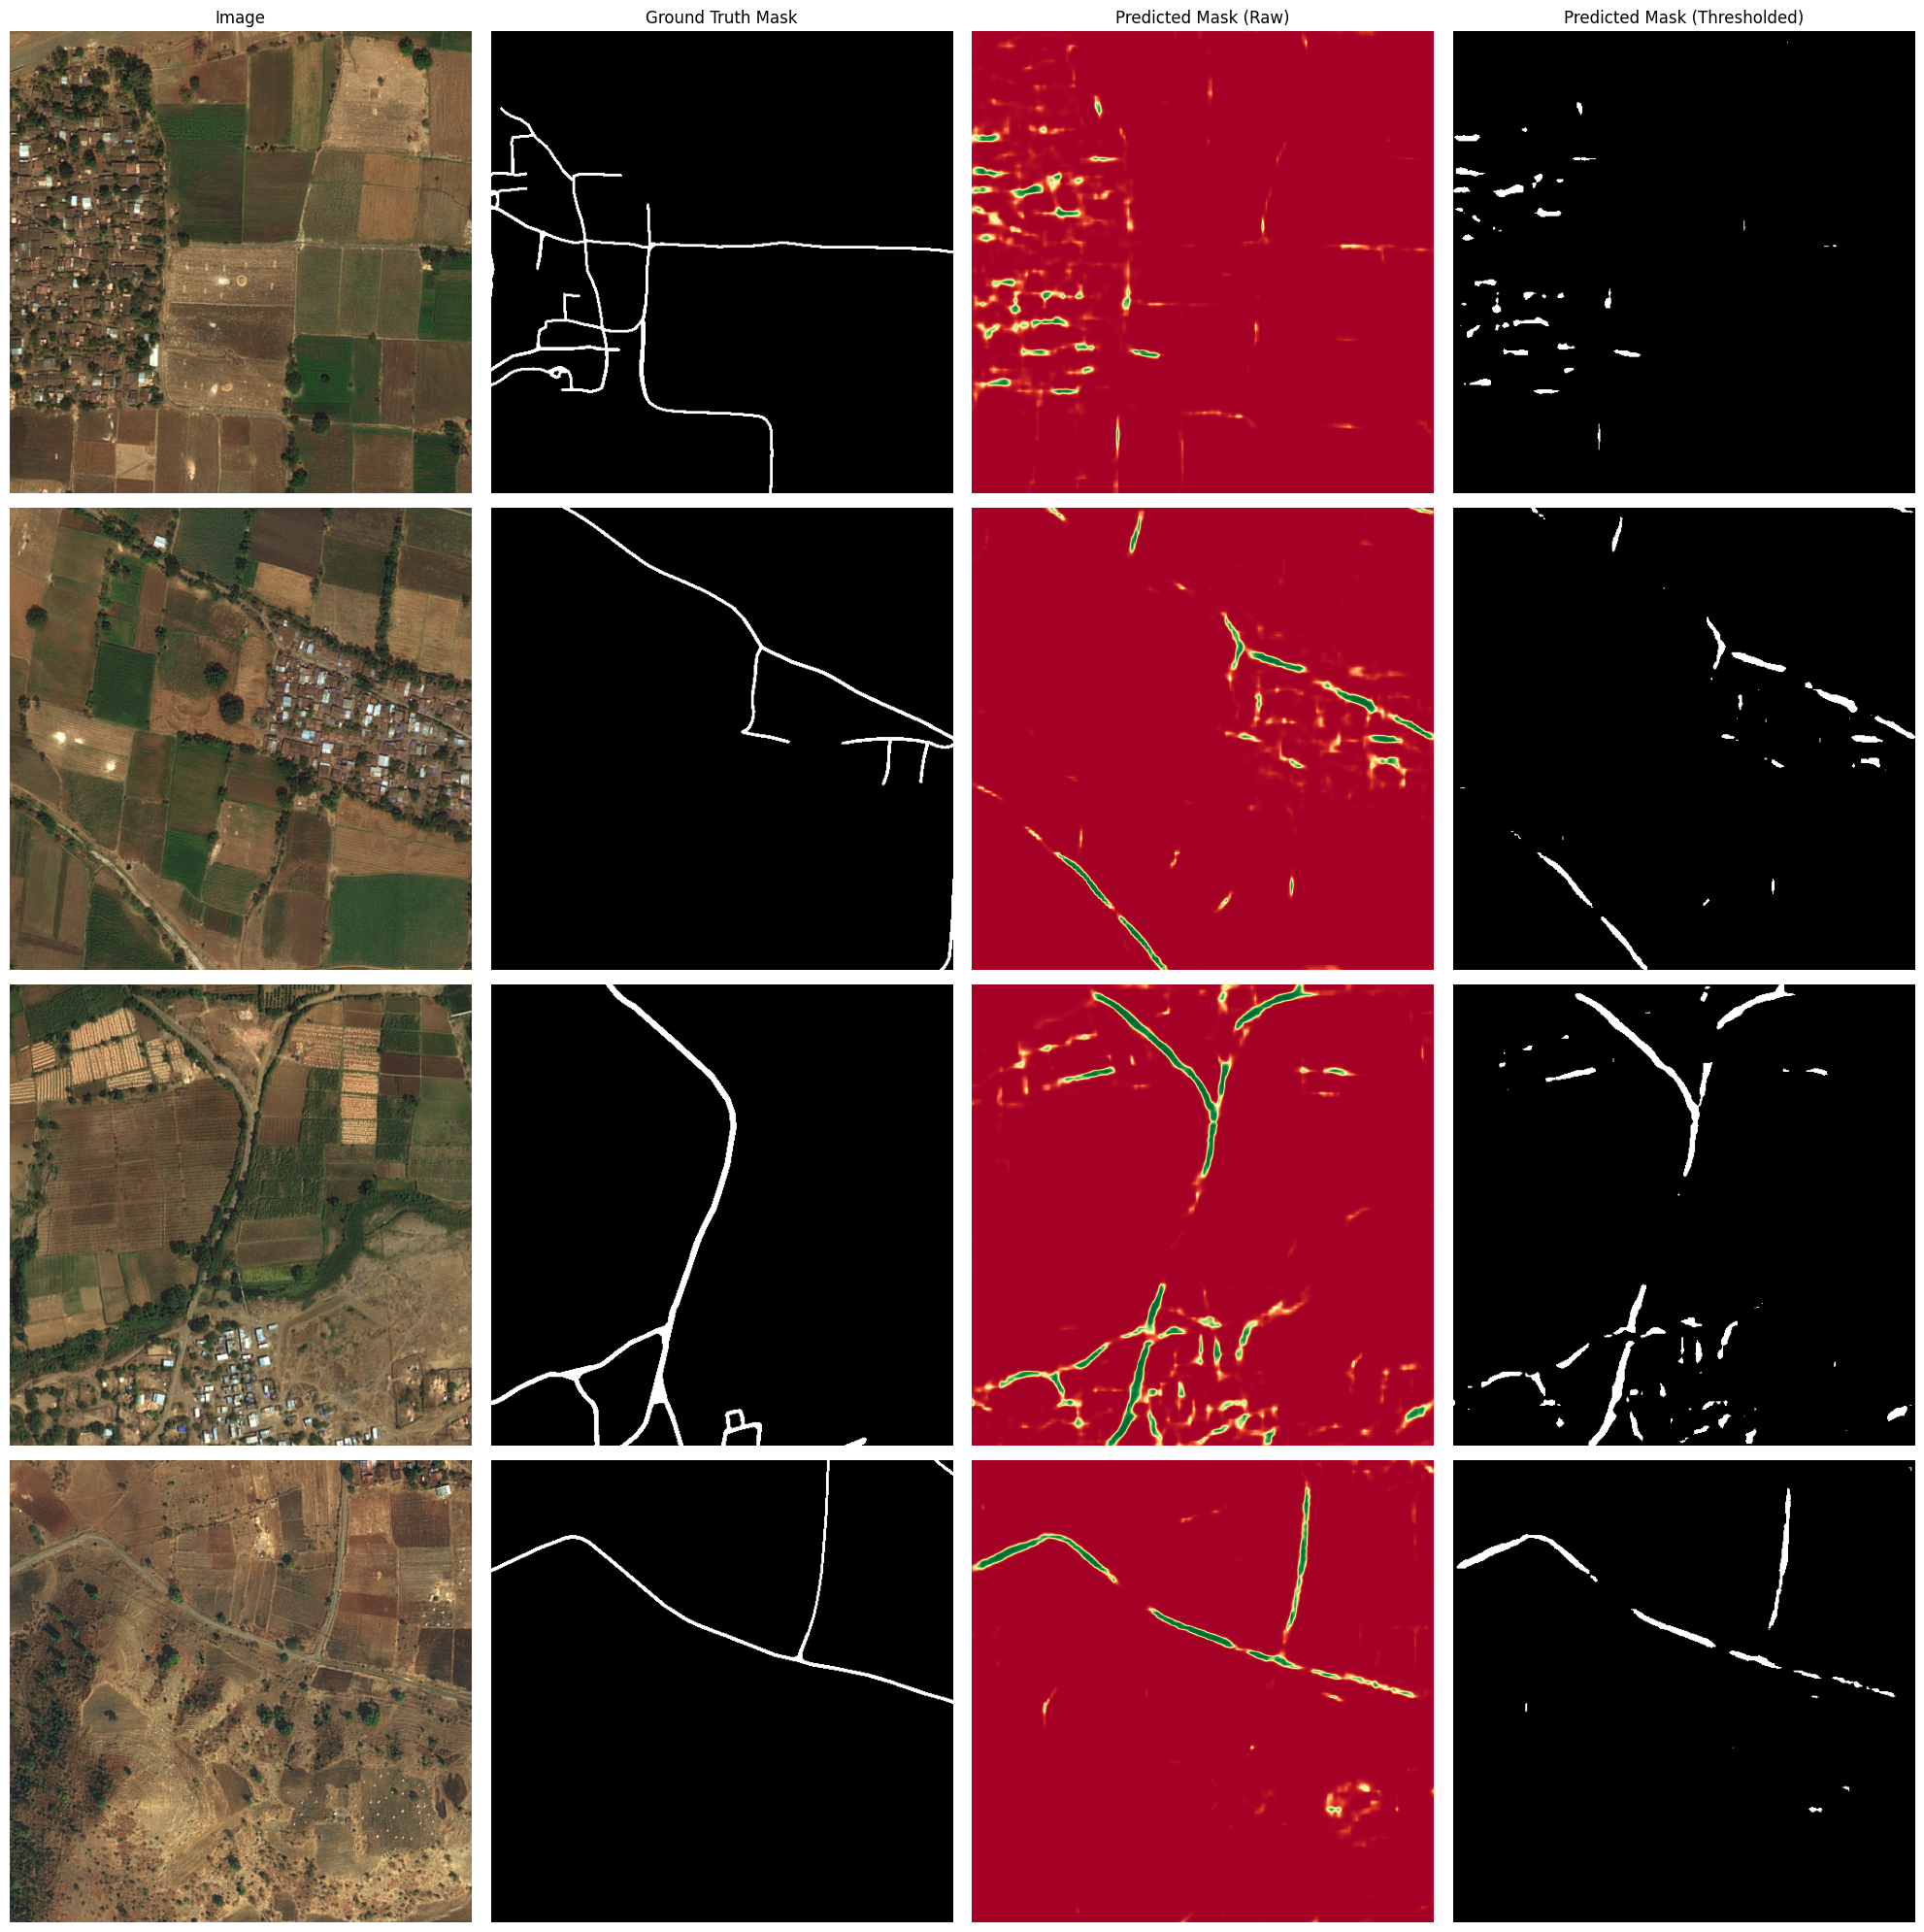

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np

dm.setup('test')

# Get the test dataloader
test_dataloader = dm.test_dataloader()

# Randomly select a batch of data
x, y = next(iter(test_dataloader))

# Put the model in evaluation mode
model.eval()

# Disable gradients for this step
with torch.no_grad():
    # Pass the data through the model
    y_hat = model(x)

# Plot the results
fig, axs = plt.subplots(4, 4, figsize=(20, 20))  # Increase the number of columns to 3
for i in range(4):
    # Plot the image
    image = np.transpose(x[i][:3, :, :]).squeeze()
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    if i == 0:
        axs[i, 0].set_title('Image')
    
    # Plot the ground truth mask
    ground_truth_mask = np.transpose(y[i]).squeeze()
    axs[i, 1].imshow(ground_truth_mask, cmap='binary_r')
    axs[i, 1].axis('off')
    if i == 0:
        axs[i, 1].set_title('Ground Truth Mask')

    # Plot the predicted mask - with and without thresholding
    predicted_mask = torch.sigmoid(np.transpose(y_hat[i])).squeeze()
    axs[i, 2].imshow(predicted_mask, cmap='RdYlGn')
    axs[i, 2].axis('off')
    if i == 0:
        axs[i, 2].set_title('Predicted Mask (Raw)')

    axs[i, 3].imshow(predicted_mask > 0.5, cmap='binary_r')
    axs[i, 3].axis('off')
    if i == 0:
        axs[i, 3].set_title('Predicted Mask (Thresholded)')
    
# Remove empty subplots
for j in range(4, 4):
    for i in range(4):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()